In [1]:
import transformers as trf
import torch as pt
import numpy as np

import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from scipy.stats import spearmanr as Sr

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
sentences = [
    'Francesco Bartolomeo Conti was born in [MASK].',
    'Francesco Bartolomeo Conti was born in Rome.',
    'Francesco Bartolomeo Conti was born in Florence.',
    'Francesco Bartolomeo Conti was born in Naples.',
    'Francesco Bartolomeo Conti was born in Venice.',
    'Francesco Bartolomeo Conti was born in Bologna.',
    'Francesco Bartolomeo Conti was born in Milan.',
    'Francesco Bartolomeo Conti was born in Turin.',
    'Francesco Bartolomeo Conti was born in Genoa.',
    'Francesco Bartolomeo Conti was born in Padua.',
    'Francesco Bartolomeo Conti was born in Parma.',
    'Francesco Bartolomeo Conti was born in Bangalore.',
    'Francesco Bartolomeo Conti was born in Perth.',
    'Francesco Bartolomeo Conti was born in Belarus.',
    'Francesco Bartolomeo Conti was born in USSR.',
    'Francesco Bartolomeo Conti was born in 1969.',
    'Barack Obama was born in Ukraine.'
]

In [3]:
class HeadlessBert(pt.nn.Module):
    def __init__(self, bert_variant='bert-base-uncased'):
        super(HeadlessBert, self).__init__()
        self.bert = trf.BertModel.from_pretrained(bert_variant)
        self.linear = pt.nn.Linear(self.bert.config.hidden_size, 
                                   self.bert.config.vocab_size, 
                                   bias=False)
        with pt.no_grad():
            self.linear.weight.copy_(self.bert.embeddings.word_embeddings.weight)

    def forward(self, X):
        return self.linear(self.bert(input_ids=X)[0])

In [4]:
class Add(pt.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.weight = pt.nn.Parameter(pt.zeros(size))
    
    def forward(self, X):
        return self.weight + X

class Scale(pt.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.weight = pt.nn.Parameter(pt.ones(size))
    
    def forward(self, X):
        return self.weight * X

In [5]:
class GeLU(pt.nn.Module):
    def __init__(self):
        super(GeLU, self).__init__()
        
    def forward(self, X):
        return pt.nn.functional.gelu(X)
    
class LMHead(pt.nn.Module):
    def __init__(self, bert_variant):
        super(LMHead, self).__init__()
        tmp = trf.BertForMaskedLM.from_pretrained(bert_variant)
        dense_w = pt.nn.Linear(tmp.config.hidden_size, 
                               tmp.config.hidden_size, 
                               bias=False)
        dense_b = Add(tmp.config.hidden_size)
        layernorm_c = pt.nn.LayerNorm(eps=tmp.config.layer_norm_eps,
                                normalized_shape=(tmp.config.hidden_size,))
        layernorm_w = Scale(tmp.config.hidden_size)
        layernorm_b = Add(tmp.config.hidden_size)
        decoder_w = pt.nn.Linear(tmp.config.hidden_size, 
                                 tmp.config.vocab_size, 
                                 bias=False)
        decoder_b = Add(tmp.config.vocab_size)
        with pt.no_grad():
            dense_w.weight.copy_(tmp.cls.predictions.transform.dense.weight)
            dense_b.weight.copy_(tmp.cls.predictions.transform.dense.bias)
            layernorm_w.weight.copy_(tmp.cls.predictions.transform.LayerNorm.weight)
            layernorm_b.weight.copy_(tmp.cls.predictions.transform.LayerNorm.bias)
            decoder_w.weight.copy_(tmp.cls.predictions.decoder.weight)
            decoder_b.weight.copy_(tmp.cls.predictions.decoder.bias)

        self.seq = pt.nn.Sequential(OrderedDict(
          [
              ('dense_weight', dense_w),
              ('dense_bias', dense_b),
              ('gelu', GeLU()),
              ('layernorm_center', layernorm_c),
              ('layernorm_scale', layernorm_w),
              ('layernorm_bias', layernorm_b),
              ('decoder_weight', decoder_w),
              ('decoder_bias', decoder_b)
          ]
        ))
        
    def forward(self, X):
        return self.seq(X)
        
class BertLMImpl(pt.nn.Module):
    def __init__(self, bert_variant='bert-base-uncased'):
        super(BertLMImpl, self).__init__()
        self.bert = trf.BertModel.from_pretrained(bert_variant)
        self.head = LMHead(bert_variant)
        
    def forward(self, X):
        return self.head(self.bert(input_ids=X)[0])

In [6]:
headlessbert = HeadlessBert()
mybertlm = BertLMImpl()

In [7]:
lmbert = trf.BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = trf.BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
mask_pos = -3
tks = pt.tensor(tokenizer.encode(sentences[0])).unsqueeze(0)
wordembeddings = lmbert.bert.embeddings.word_embeddings.weight.detach().numpy()

In [9]:
def some_plots(name, orders_dict, values_dict):
    def wrapped(module, Xin):
        mask_in = Xin[0].squeeze()[mask_pos]
        if name not in ('decoder_bias',):
            dots = np.matmul(wordembeddings, mask_in)
            orders_dict[name] = np.argsort(dots)
            values_dict[name] = dots
        else:
            orders_dict[name] = np.argsort(mask_in)
            values_dict[name] = mask_in
    return wrapped

In [10]:
hooks_lm = {}
orders_lm = {}
values_lm = {}
for name, mod in mybertlm.head.seq.named_children():
    hooks_lm[name] = mod.register_forward_pre_hook(some_plots(name, orders_lm, values_lm))

In [11]:
with pt.no_grad():
    mybertlmout = mybertlm(tks)
mybertlmout_values = mybertlmout.squeeze()[mask_pos]
mybertlmout_order = np.argsort(mybertlmout_values)
mybertlmout

tensor([[[ -6.8071,  -6.7780,  -6.7688,  ...,  -6.1409,  -5.9730,  -3.9125],
         [ -5.7102,  -5.6887,  -5.3438,  ...,  -5.1681,  -7.7788,  -4.3432],
         [ -9.8116, -10.1511,  -9.9938,  ...,  -9.5364, -11.4856,  -8.7943],
         ...,
         [ -4.3352,  -4.2403,  -4.4529,  ...,  -4.4164,  -5.8905,  -2.0324],
         [-12.9668, -12.4438, -13.0035,  ..., -10.1453, -11.5883,  -7.8451],
         [-12.7029, -12.2706, -12.6628,  ...,  -9.9292, -12.0298,  -7.5945]]])

In [12]:
lmbert(tks)

(tensor([[[ -6.8071,  -6.7780,  -6.7688,  ...,  -6.1409,  -5.9730,  -3.9125],
          [ -5.7102,  -5.6887,  -5.3438,  ...,  -5.1681,  -7.7788,  -4.3432],
          [ -9.8116, -10.1511,  -9.9938,  ...,  -9.5364, -11.4856,  -8.7943],
          ...,
          [ -4.3352,  -4.2403,  -4.4529,  ...,  -4.4164,  -5.8905,  -2.0324],
          [-12.9668, -12.4438, -13.0035,  ..., -10.1453, -11.5883,  -7.8451],
          [-12.7029, -12.2706, -12.6628,  ...,  -9.9292, -12.0298,  -7.5945]]],
        grad_fn=<AddBackward0>),)

In [13]:
with pt.no_grad():
    headlessbertout = headlessbert(tks)
    headless_values = headlessbertout.squeeze()[mask_pos]
    headless_order = np.argsort(headless_values)

In [14]:
lmbert.bert.embeddings.word_embeddings.weight is lmbert.cls.predictions.decoder.weight

True

In [15]:
orders_lm

{'dense_weight': tensor([13596, 13492, 24564,  ...,   102,   103,   101]),
 'dense_bias': tensor([ 1208, 25910,  1214,  ...,  1998,  2028,  2034]),
 'gelu': tensor([25910,  1208,  1214,  ...,  1998,  2028,  2034]),
 'layernorm_center': tensor([25535, 28122, 29359,  ...,   102,   103,   101]),
 'layernorm_scale': tensor([29313, 30118, 30069,  ..., 14102,  4199, 13667]),
 'layernorm_bias': tensor([ 9654, 27921, 28394,  ...,  4199, 13667, 14102]),
 'decoder_weight': tensor([27921,  9654, 28394,  ...,  7914, 10553,  4199]),
 'decoder_bias': tensor([27921,  9654, 28394,  ...,  7914, 10553,  4199])}

In [16]:
list(reversed(tokenizer.convert_ids_to_tokens(orders_lm['gelu'][-20:])))

['first',
 'one',
 'and',
 'in',
 'there',
 'all',
 'time',
 '-',
 'it',
 'work',
 'a',
 ',',
 'this',
 'only',
 'for',
 'back',
 'home',
 'that',
 "'",
 'life']

In [17]:
list(reversed(tokenizer.convert_ids_to_tokens(orders_lm['layernorm_center'][-20:])))

['[CLS]',
 '[MASK]',
 '[SEP]',
 'there',
 'here',
 "'",
 'time',
 'after',
 'in',
 'home',
 'for',
 ':',
 'first',
 'under',
 'to',
 'around',
 'too',
 'right',
 '(',
 'by']

In [18]:
list(reversed(tokenizer.convert_ids_to_tokens(orders_lm['layernorm_scale'][-20:])))

['turin',
 'rome',
 'bologna',
 'pisa',
 'milan',
 'parma',
 'como',
 'florence',
 'roma',
 'venice',
 'padua',
 'genoa',
 'siena',
 '##zio',
 'lax',
 'alfa',
 'ada',
 'fig',
 'split',
 'dir']

In [19]:
list(reversed(tokenizer.convert_ids_to_tokens(orders_lm['layernorm_bias'][-20:])))

['bologna',
 'turin',
 'rome',
 'naples',
 'florence',
 'venice',
 'genoa',
 'milan',
 'parma',
 'padua',
 'pisa',
 'palermo',
 'trieste',
 'ferrara',
 'siena',
 'verona',
 'roma',
 'como',
 'milano',
 'torino']

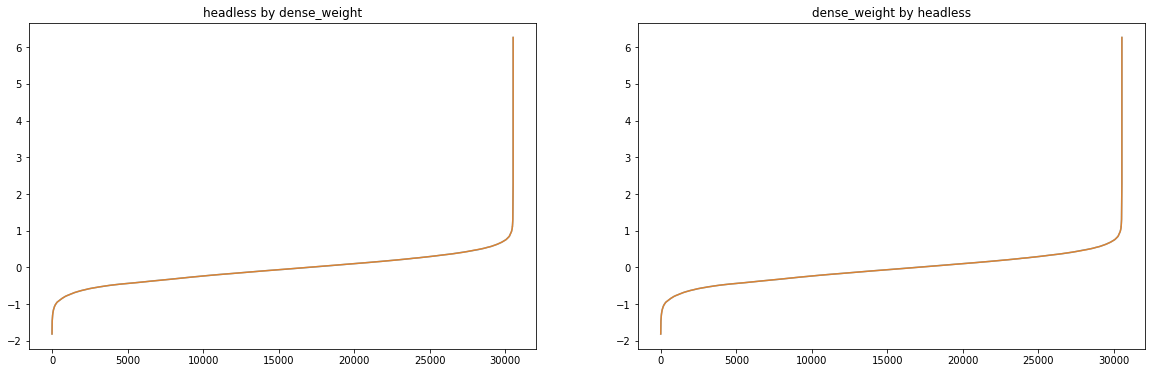

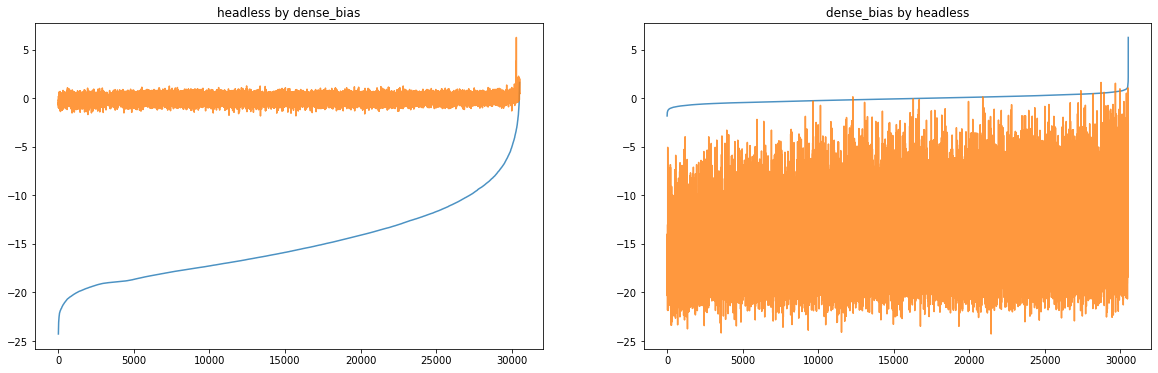

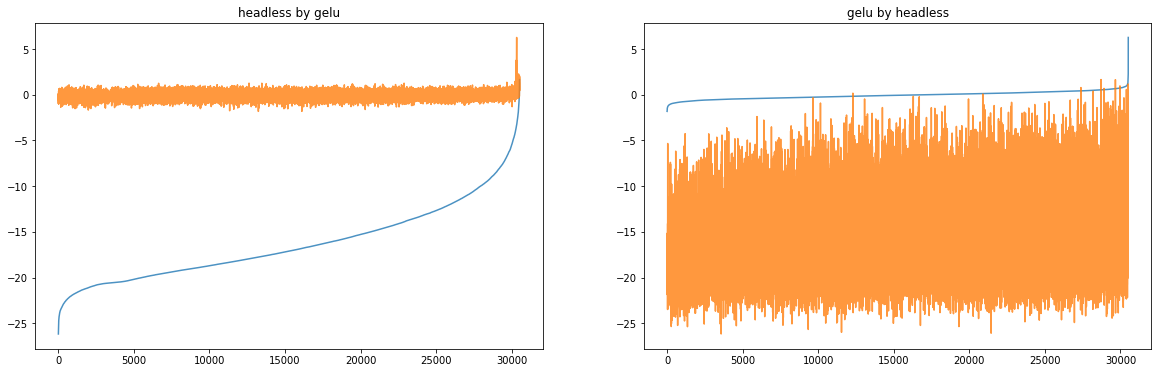

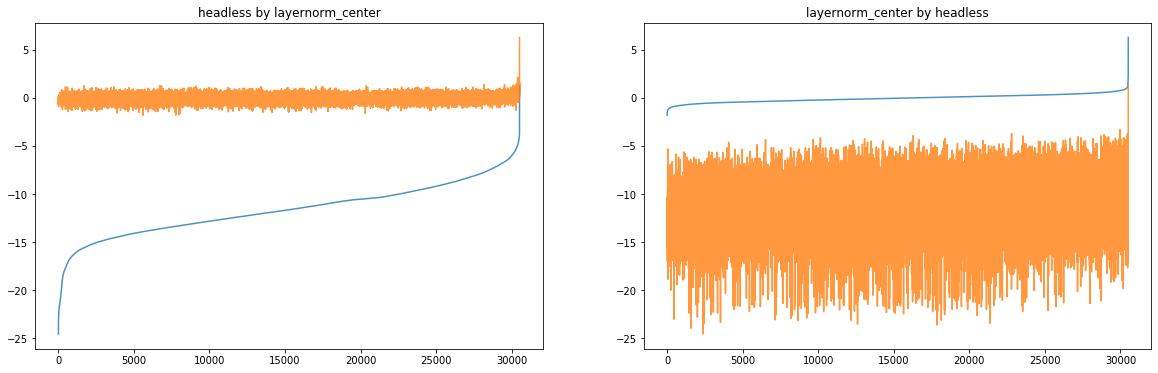

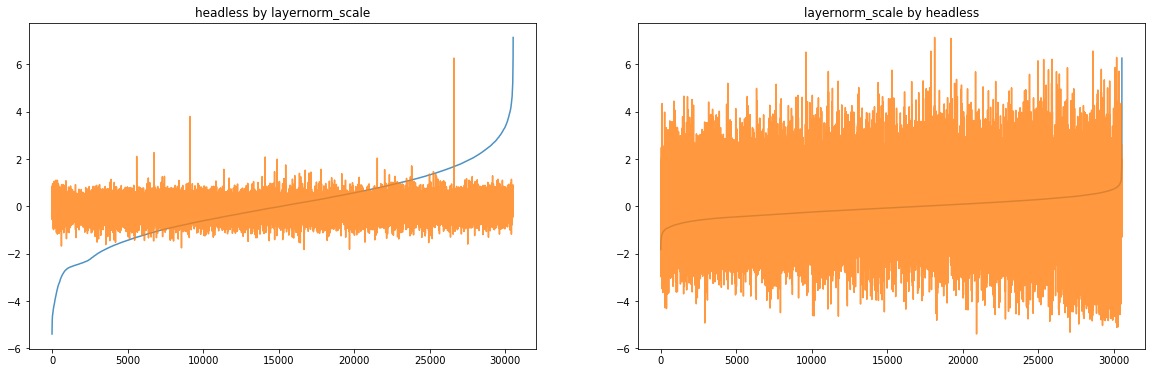

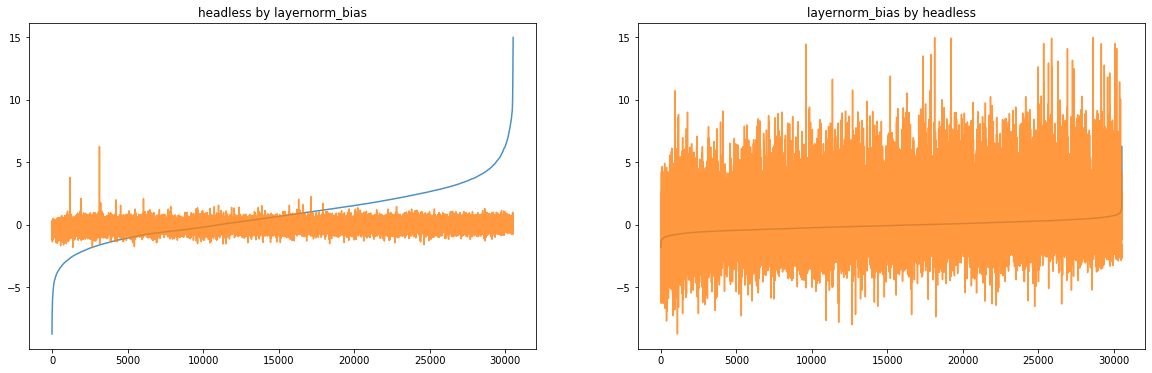

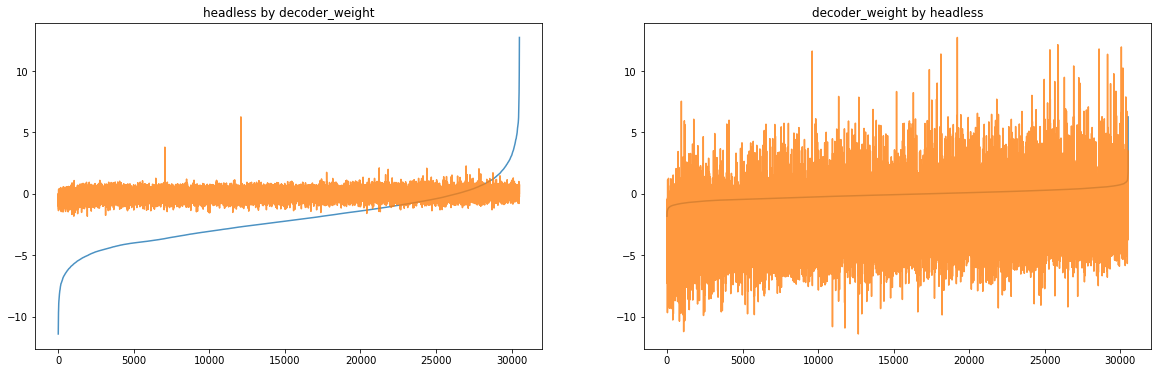

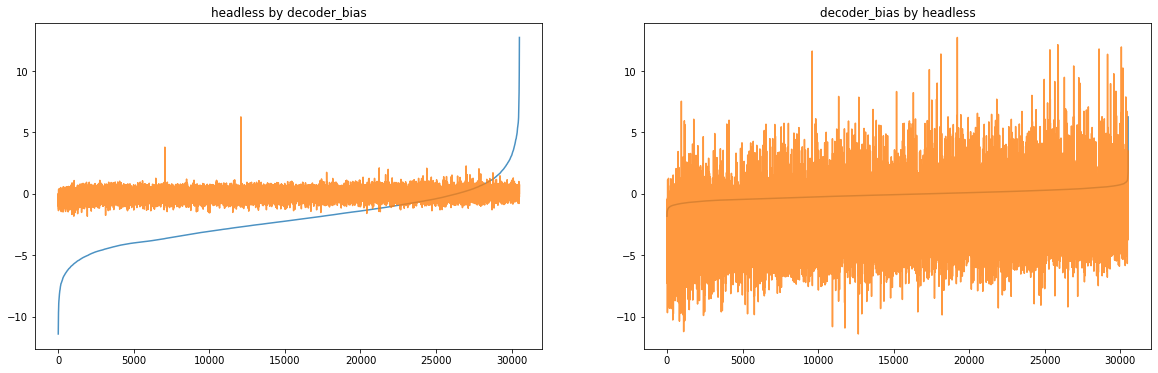

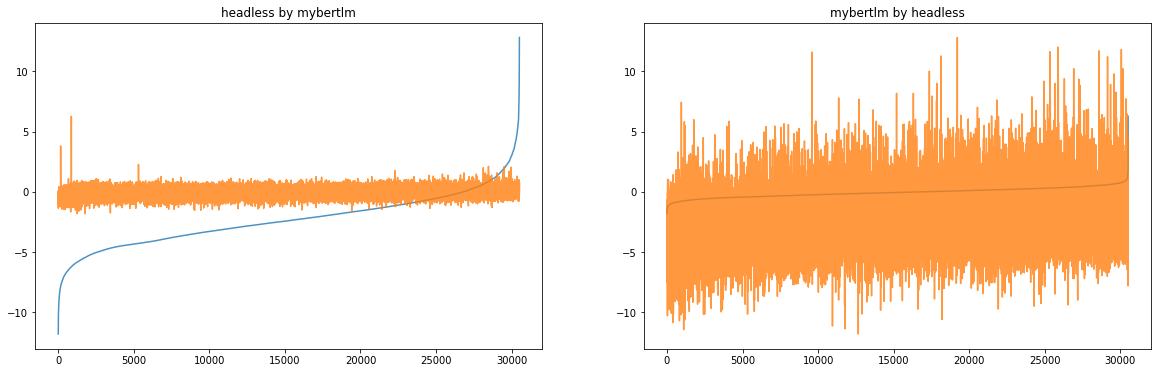

In [20]:
def plot_one(name, values, order):
    fig = plt.figure(figsize=(20, 6))
    ax1, ax2 = fig.subplots(1, 2)

    ax1.plot(values[order], alpha=.8)
    ax1.plot(headless_values[order], alpha=.8)
    ax1.set_title(f'headless by {name}')

    ax2.plot(headless_values[headless_order], alpha=.8)
    ax2.plot(values[headless_order], alpha=.8)
    ax2.set_title(f'{name} by headless')

    plt.show()
    fig.savefig(f'{name} vs headless.png')
    plt.close(fig)

with pt.no_grad():
    for name, order in orders_lm.items():
        plot_one(name, values_lm[name], order)
    plot_one('mybertlm', mybertlmout_values, mybertlmout_order)
        

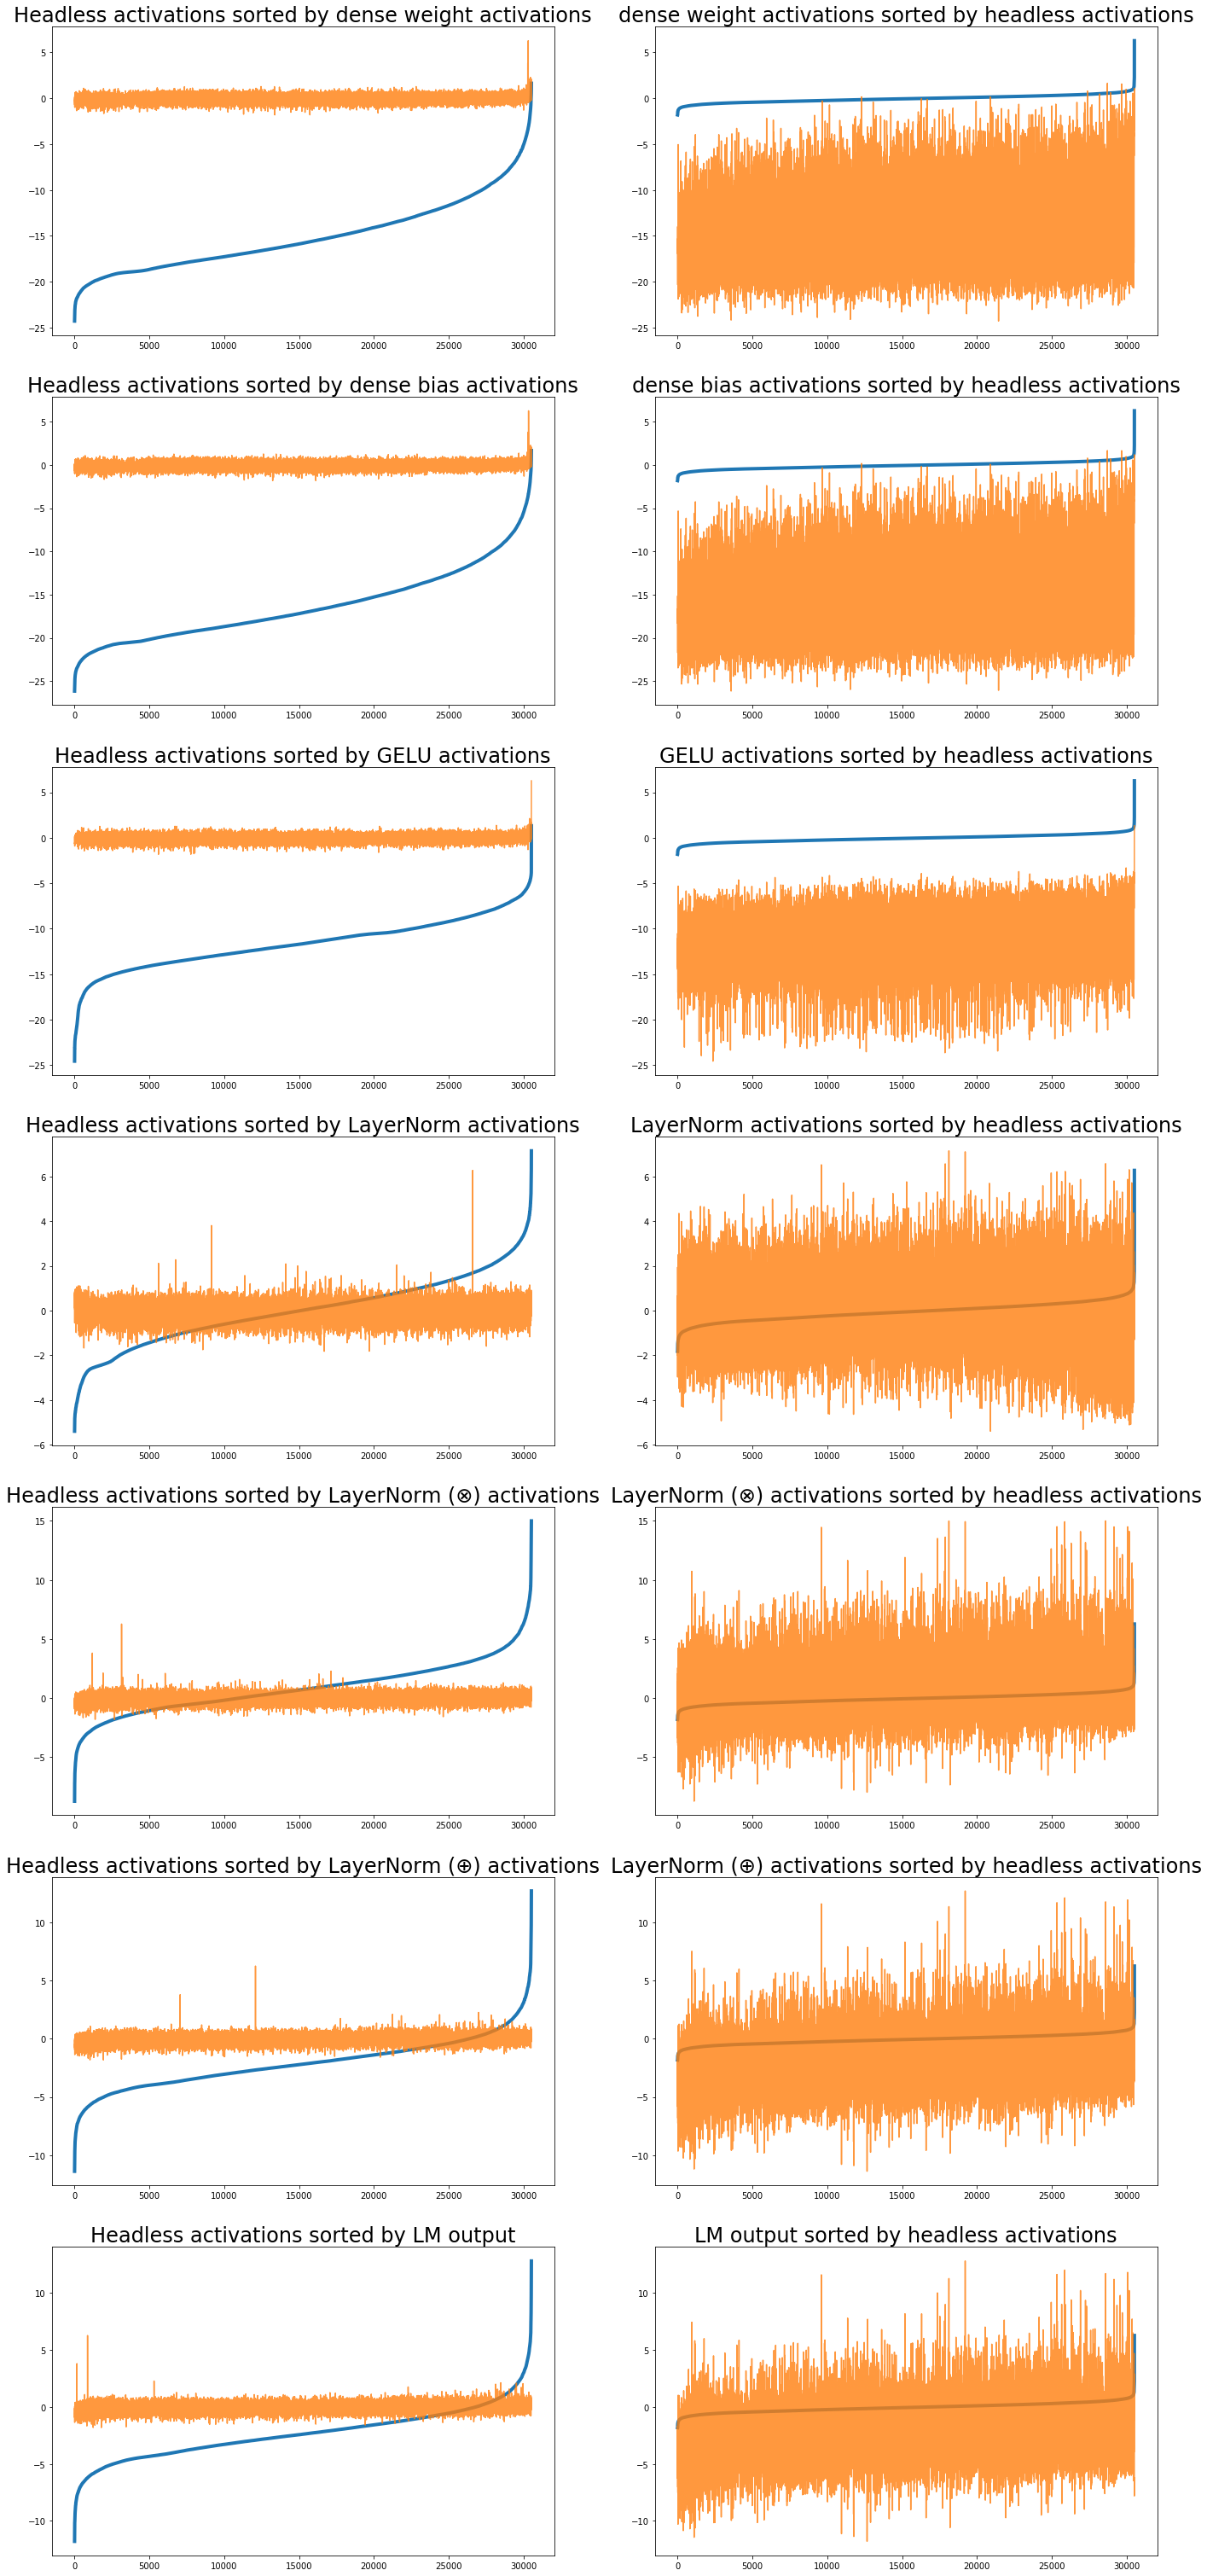

In [21]:
with pt.no_grad():
    n_items = len(orders_lm) - 1
    fig = plt.figure(figsize=(20, 6 * n_items))
    axes = fig.subplots(n_items, 2)
    nice_names = ['headless activations',
                  'dense weight activations',
                  'dense bias activations',
                  'GELU activations',
                  'LayerNorm activations',
                  'LayerNorm (⊗) activations',
                  'LayerNorm (⊕) activations']
    for (i, (name, order)) in enumerate(orders_lm.items()):
        if i >= n_items:
            break
        if i == 0:
            continue
        axes[i-1][0].plot(values_lm[name][order], alpha=1, linewidth=4)
        axes[i-1][0].plot(headless_values[order], alpha=.8)
        axes[i-1][0].set_title(f'Headless activations sorted by {nice_names[i]}', fontsize=24)
        axes[i-1][1].plot(headless_values[headless_order], alpha=1, linewidth=4)
        axes[i-1][1].plot(values_lm[name][headless_order], alpha=.8)
        axes[i-1][1].set_title(f'{nice_names[i]} sorted by headless activations', fontsize=24)
    axes[6][0].plot(mybertlmout_values[mybertlmout_order], alpha=1, linewidth=4)
    axes[6][0].plot(headless_values[mybertlmout_order], alpha=.8)
    axes[6][0].set_title(f'Headless activations sorted by LM output', fontsize=24)
    axes[6][1].plot(headless_values[headless_order], alpha=1, linewidth=4)
    axes[6][1].plot(mybertlmout_values[headless_order], alpha=.8)
    axes[6][1].set_title(f'LM output sorted by headless activations', fontsize=24)
    plt.subplots_adjust(left=.05, bottom=.01, right=.95, top=.99, wspace=None, hspace=None)
    plt.show(fig)  
    fig.savefig('1 - all vs headless.png')
    plt.close(fig)

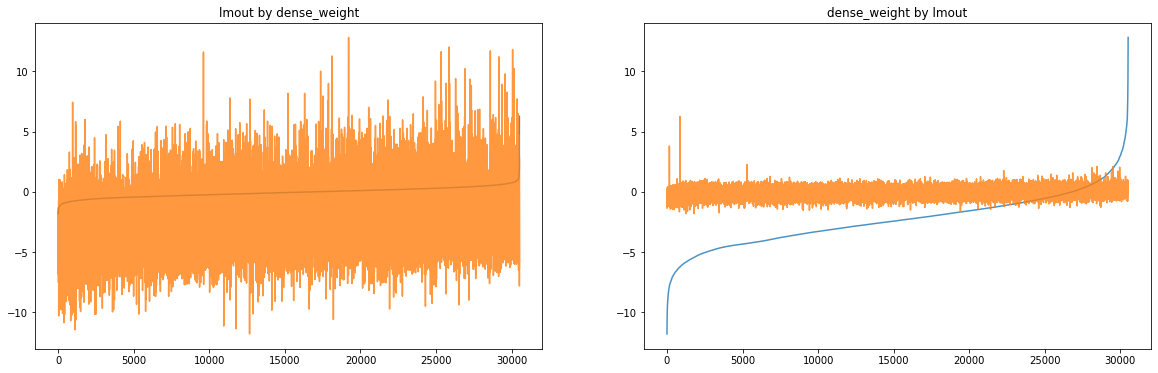

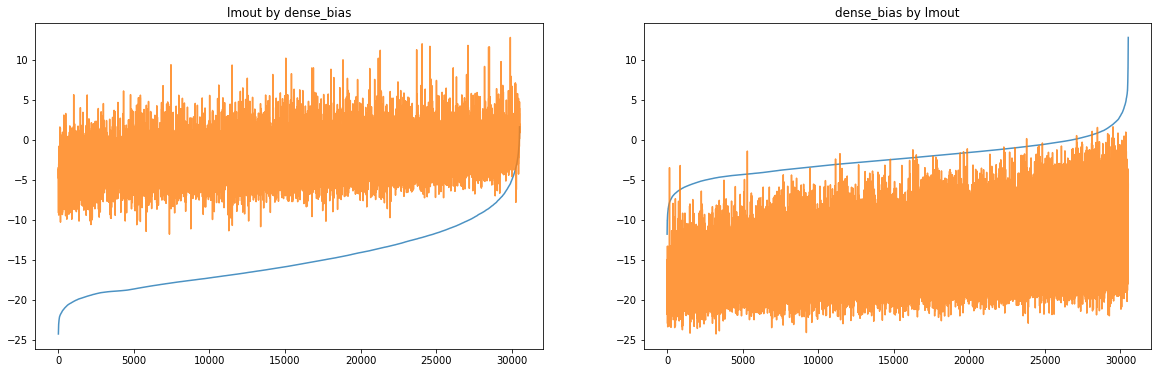

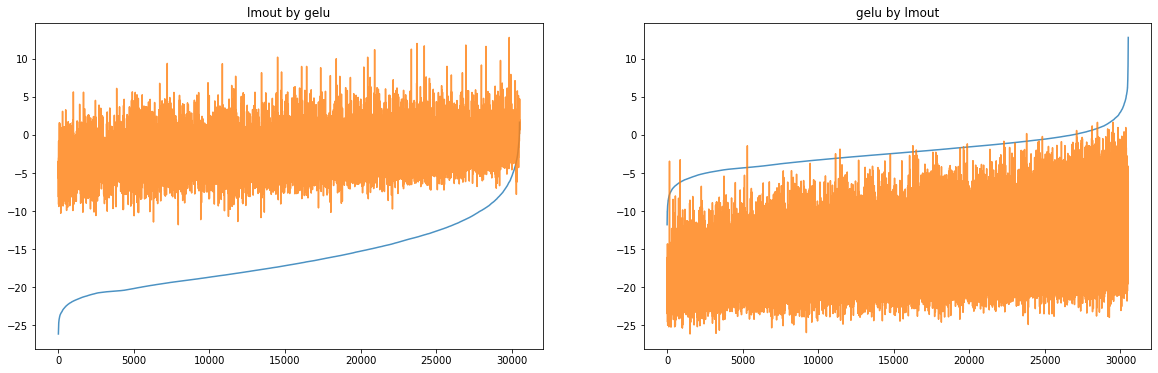

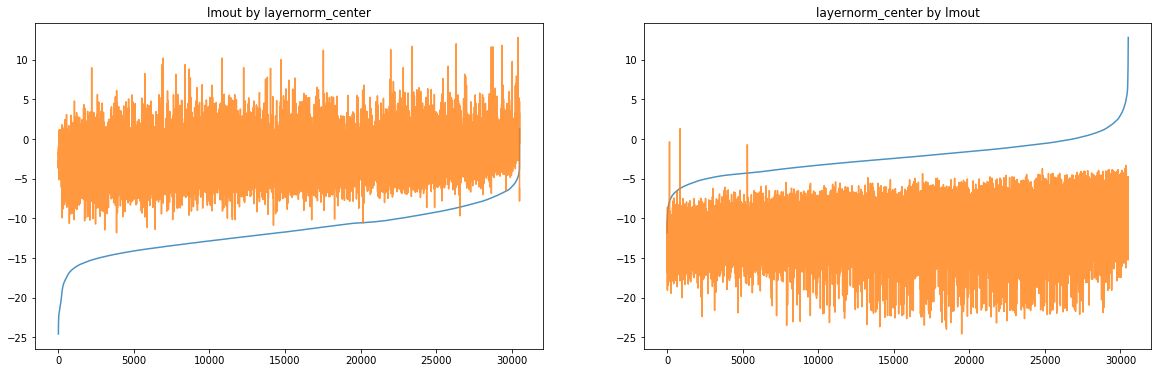

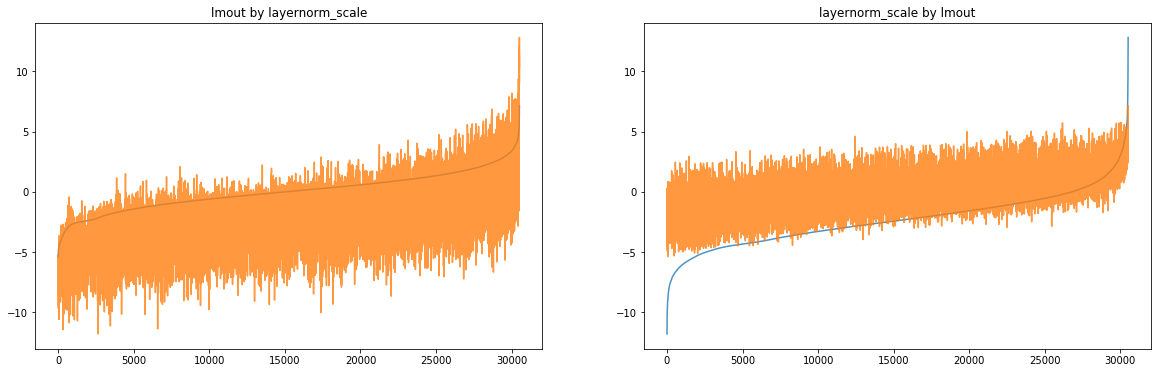

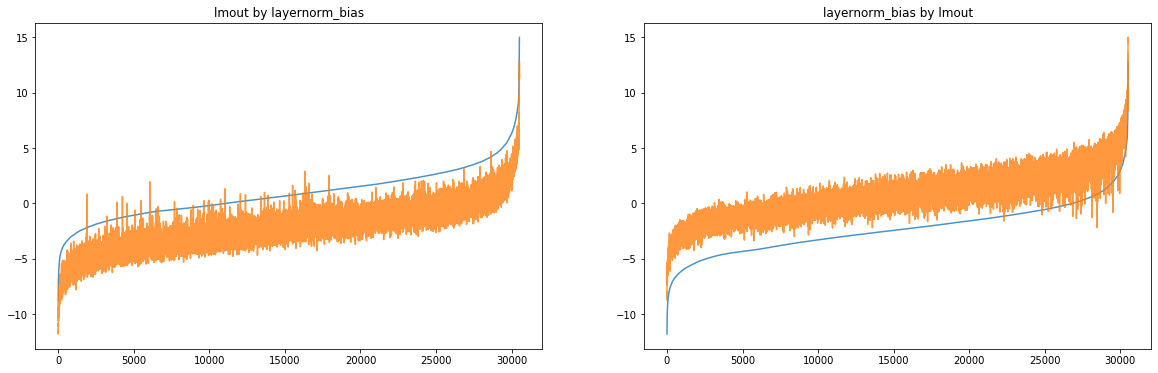

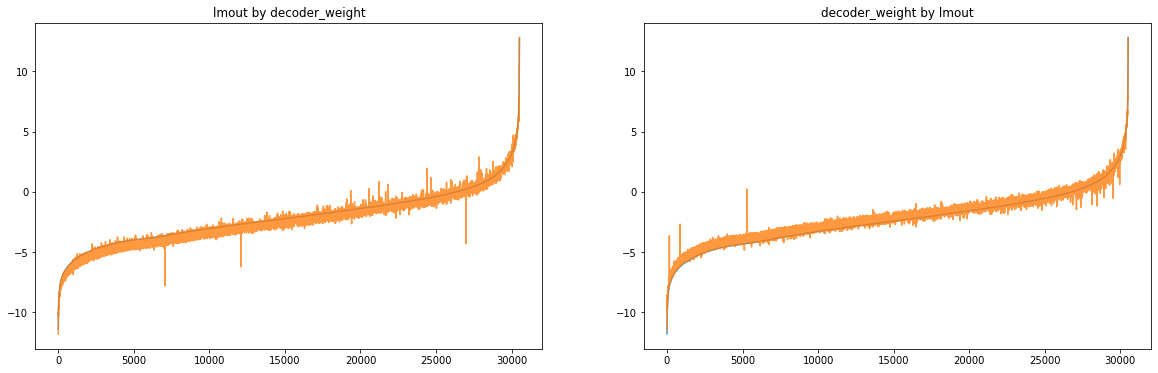

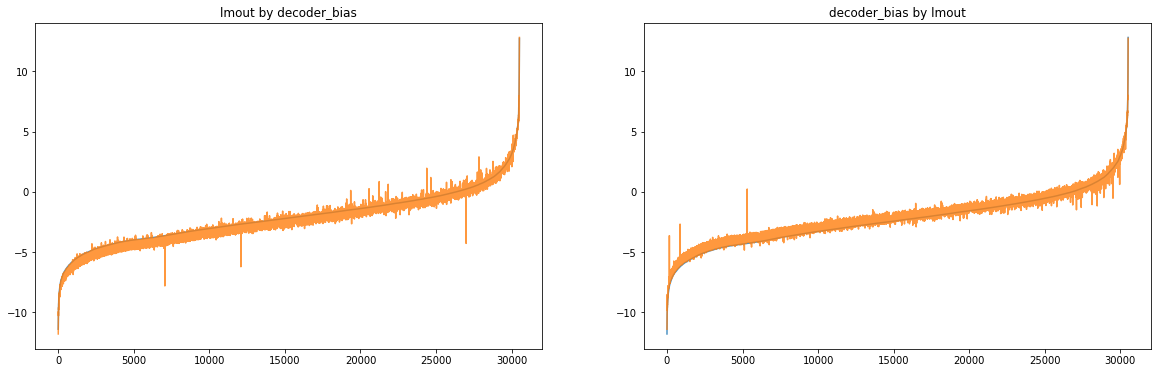

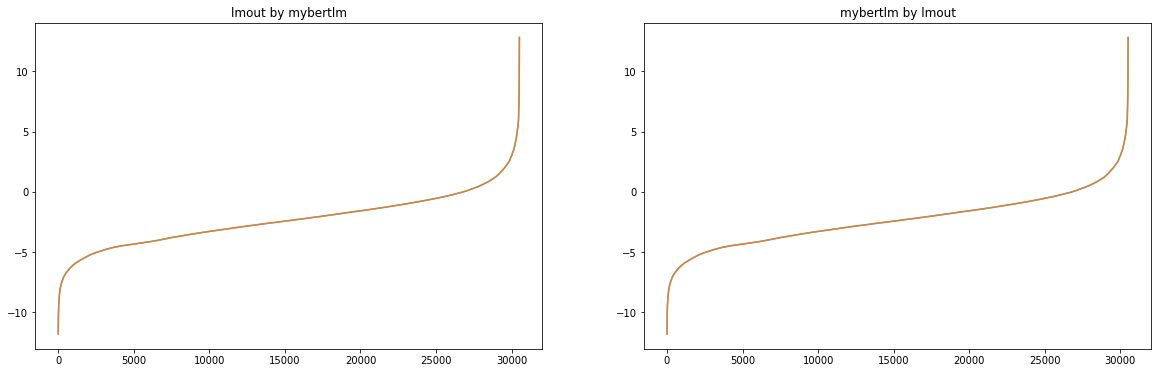

In [22]:
def plot_two(name, values, order):
    fig = plt.figure(figsize=(20, 6))
    ax1, ax2 = fig.subplots(1, 2)

    ax1.plot(values[order], alpha=.8)
    ax1.plot(mybertlmout_values[order], alpha=.8)
    ax1.set_title(f'lmout by {name}')

    ax2.plot(mybertlmout_values[mybertlmout_order], alpha=.8)
    ax2.plot(values[mybertlmout_order], alpha=.8)
    ax2.set_title(f'{name} by lmout')

    plt.show()
    fig.savefig(f'{name} vs lmout.png')
    plt.close(fig)

with pt.no_grad():
    for name, order in orders_lm.items():
        plot_two(name, values_lm[name], order)
    plot_two('mybertlm', mybertlmout_values, mybertlmout_order)
        

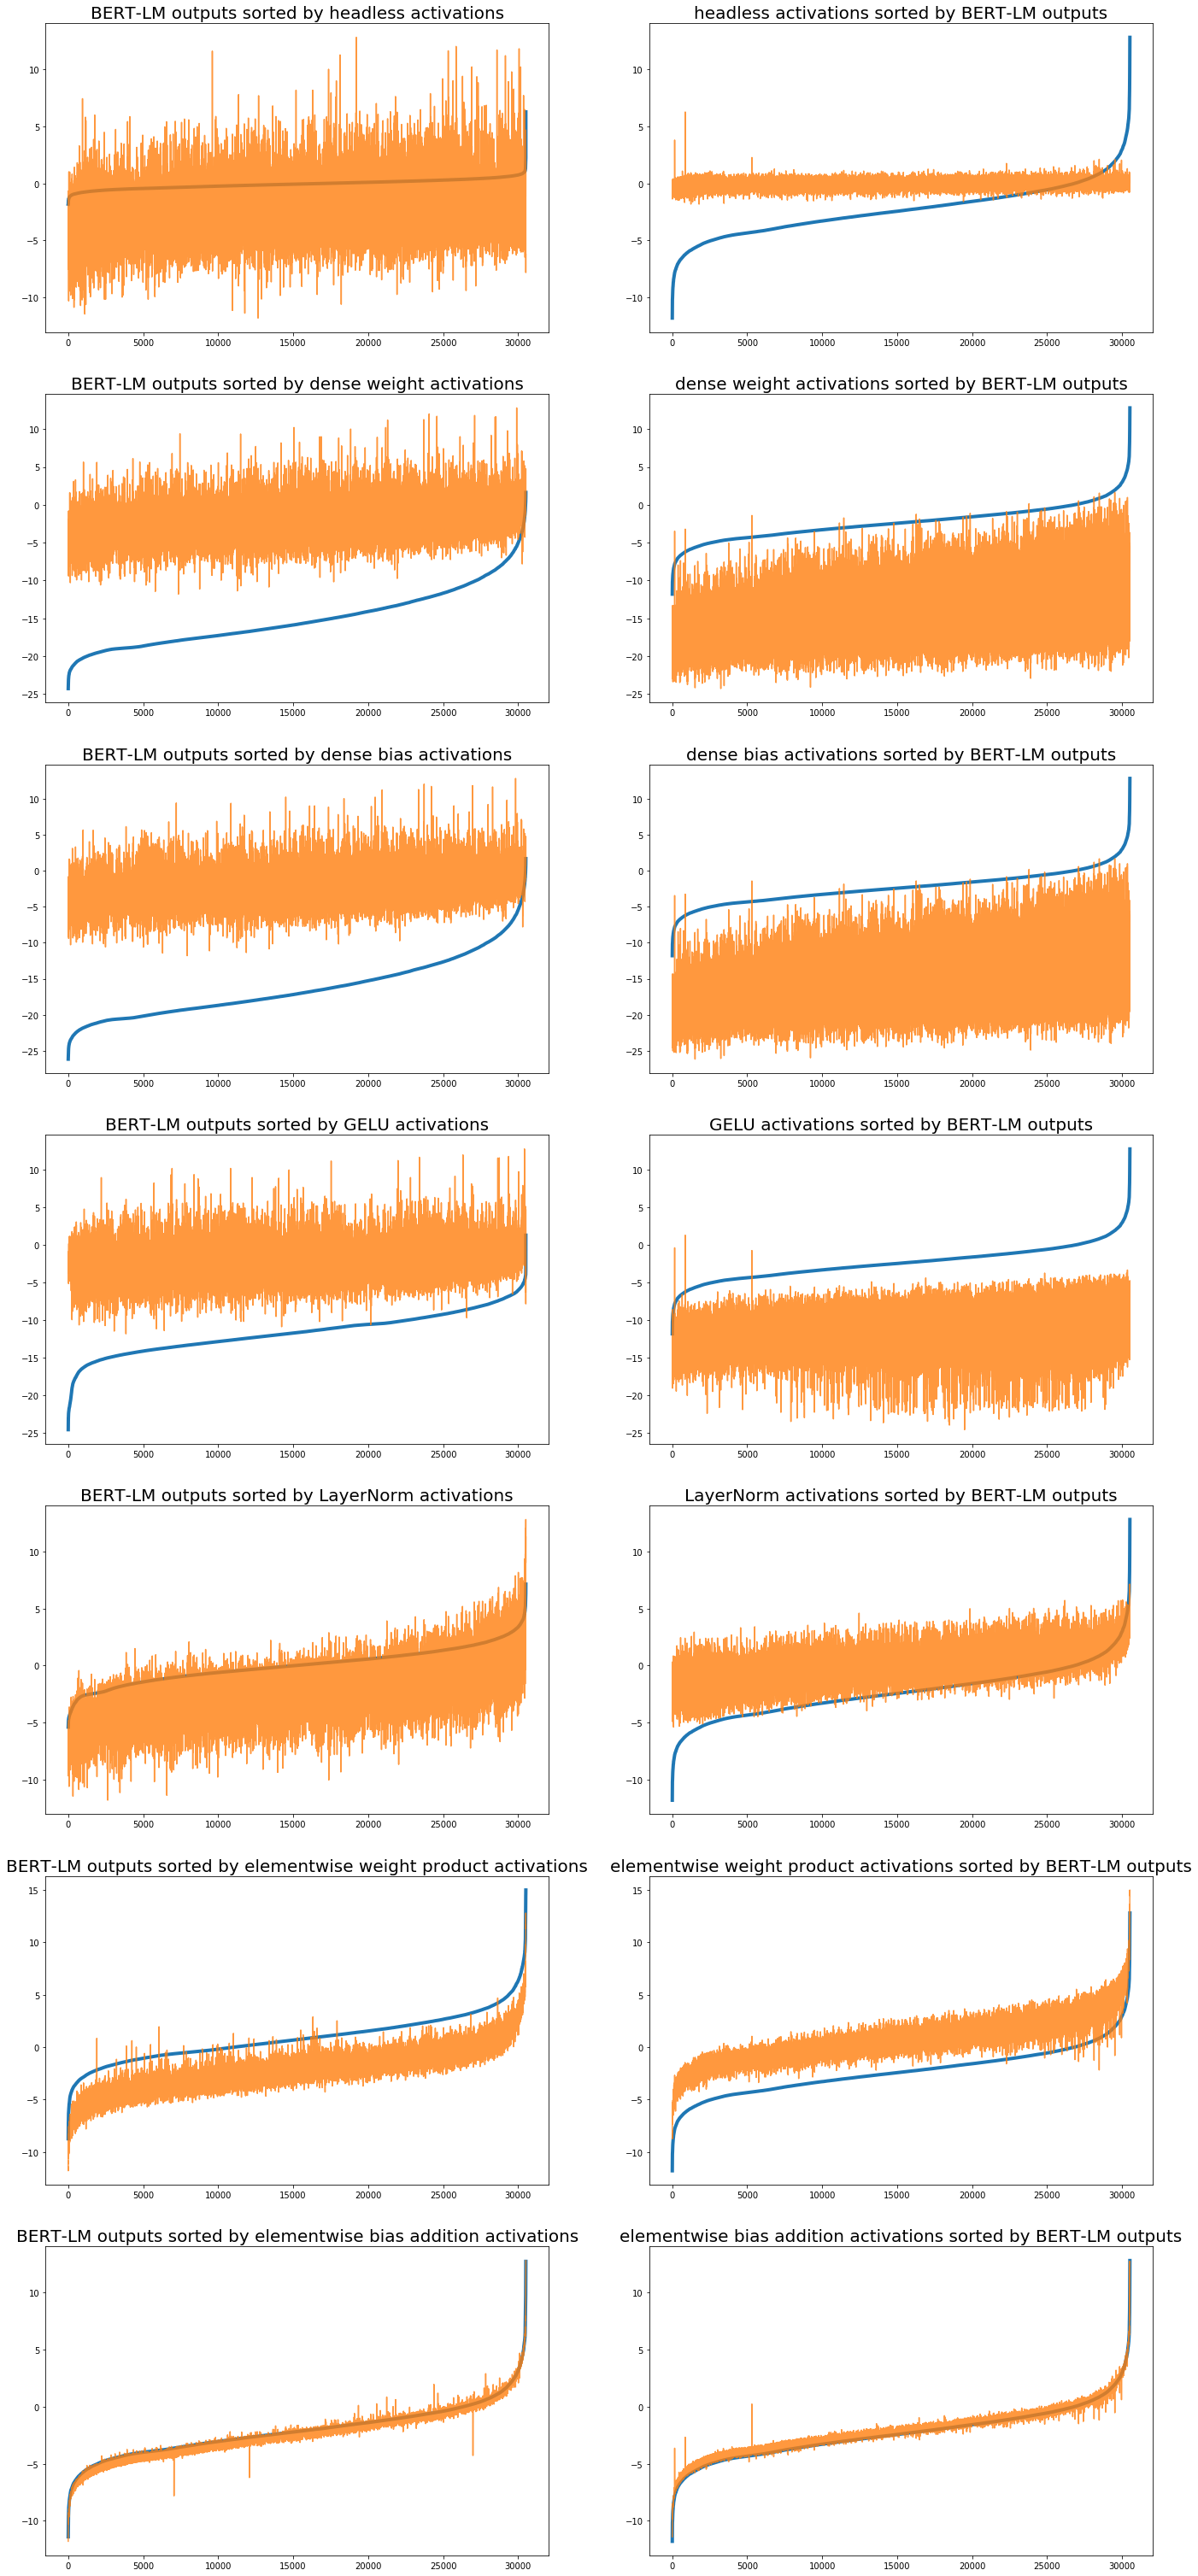

In [23]:
with pt.no_grad():
    n_items = len(orders_lm) - 1
    fig = plt.figure(figsize=(20, 6 * n_items))
    axes = fig.subplots(n_items, 2)
    nice_names = ['headless activations',
                  'dense weight activations',
                  'dense bias activations',
                  'GELU activations',
                  'LayerNorm activations',
                  'elementwise weight product activations',
                  'elementwise bias addition activations']
    for (i, (name, order)) in enumerate(orders_lm.items()):
        if i >= n_items:
            break
        axes[i][0].plot(values_lm[name][order], alpha=1, linewidth=4)
        axes[i][0].plot(mybertlmout_values[order], alpha=.8)
        axes[i][0].set_title(f'BERT-LM outputs sorted by {nice_names[i]}', fontsize=20)
        axes[i][1].plot(mybertlmout_values[mybertlmout_order], alpha=1, linewidth=4)
        axes[i][1].plot(values_lm[name][mybertlmout_order], alpha=.8)
        axes[i][1].set_title(f'{nice_names[i]} sorted by BERT-LM outputs', fontsize=20)
    plt.subplots_adjust(left=.05, bottom=.01, right=.95, top=.99, wspace=None, hspace=None)

    plt.show(fig)    
    fig.savefig('2 - all vs lmout.png')
    plt.close(fig)

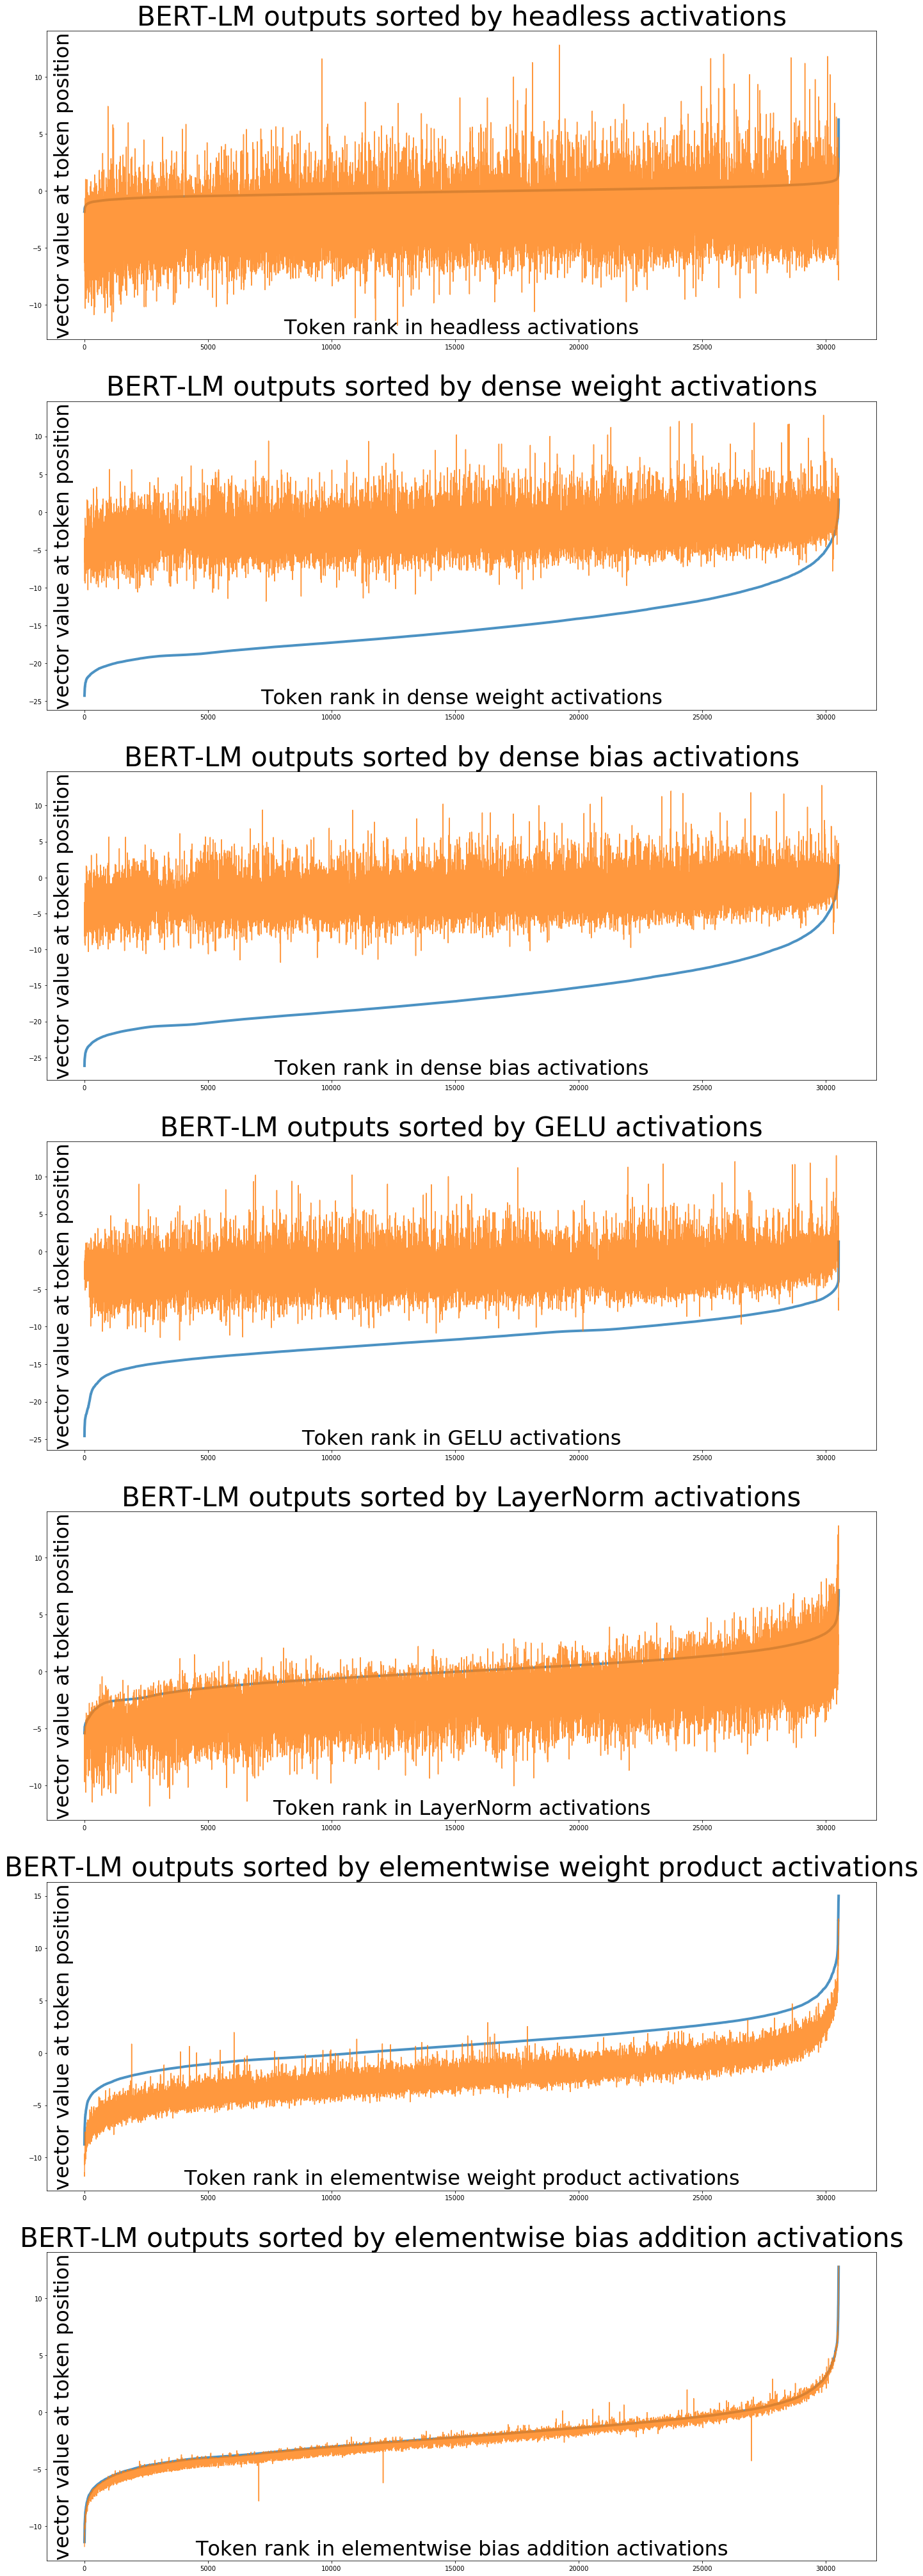

In [24]:

with pt.no_grad():
    n_items = len(orders_lm) - 1
    fig = plt.figure(figsize=(20, 8 * n_items))
    axes = fig.subplots(n_items, 1)
    nice_names = ['headless activations',
                  'dense weight activations',
                  'dense bias activations',
                  'GELU activations',
                  'LayerNorm activations',
                  'elementwise weight product activations',
                  'elementwise bias addition activations']
    for (i, (name, order)) in enumerate(orders_lm.items()):
        if i >= n_items:
            break
        axes[i].plot(values_lm[name][order], alpha=.8, linewidth=4)
        axes[i].plot(mybertlmout_values[order], alpha=.8)
        axes[i].set_title(f'BERT-LM outputs sorted by {nice_names[i]}', fontsize=42)
        axes[i].set_xlabel(f'Token rank in {nice_names[i]}', fontsize=32, labelpad=-50)
        axes[i].set_ylabel('vector value at token position', fontsize=32, labelpad=-70)
#         axes[i][1].plot(mybertlmout_values[mybertlmout_order], alpha=.8)
#         axes[i][1].plot(values_lm[name][mybertlmout_order], alpha=.8)
#         axes[i][1].set_title(f'{name} by lmout', fontsize=24)
    plt.subplots_adjust(left=.05, bottom=.01, right=.95, top=.99, wspace=None, hspace=None)
    plt.show()
    fig.savefig('2.m - all vs lmout.png')
    plt.close(fig)

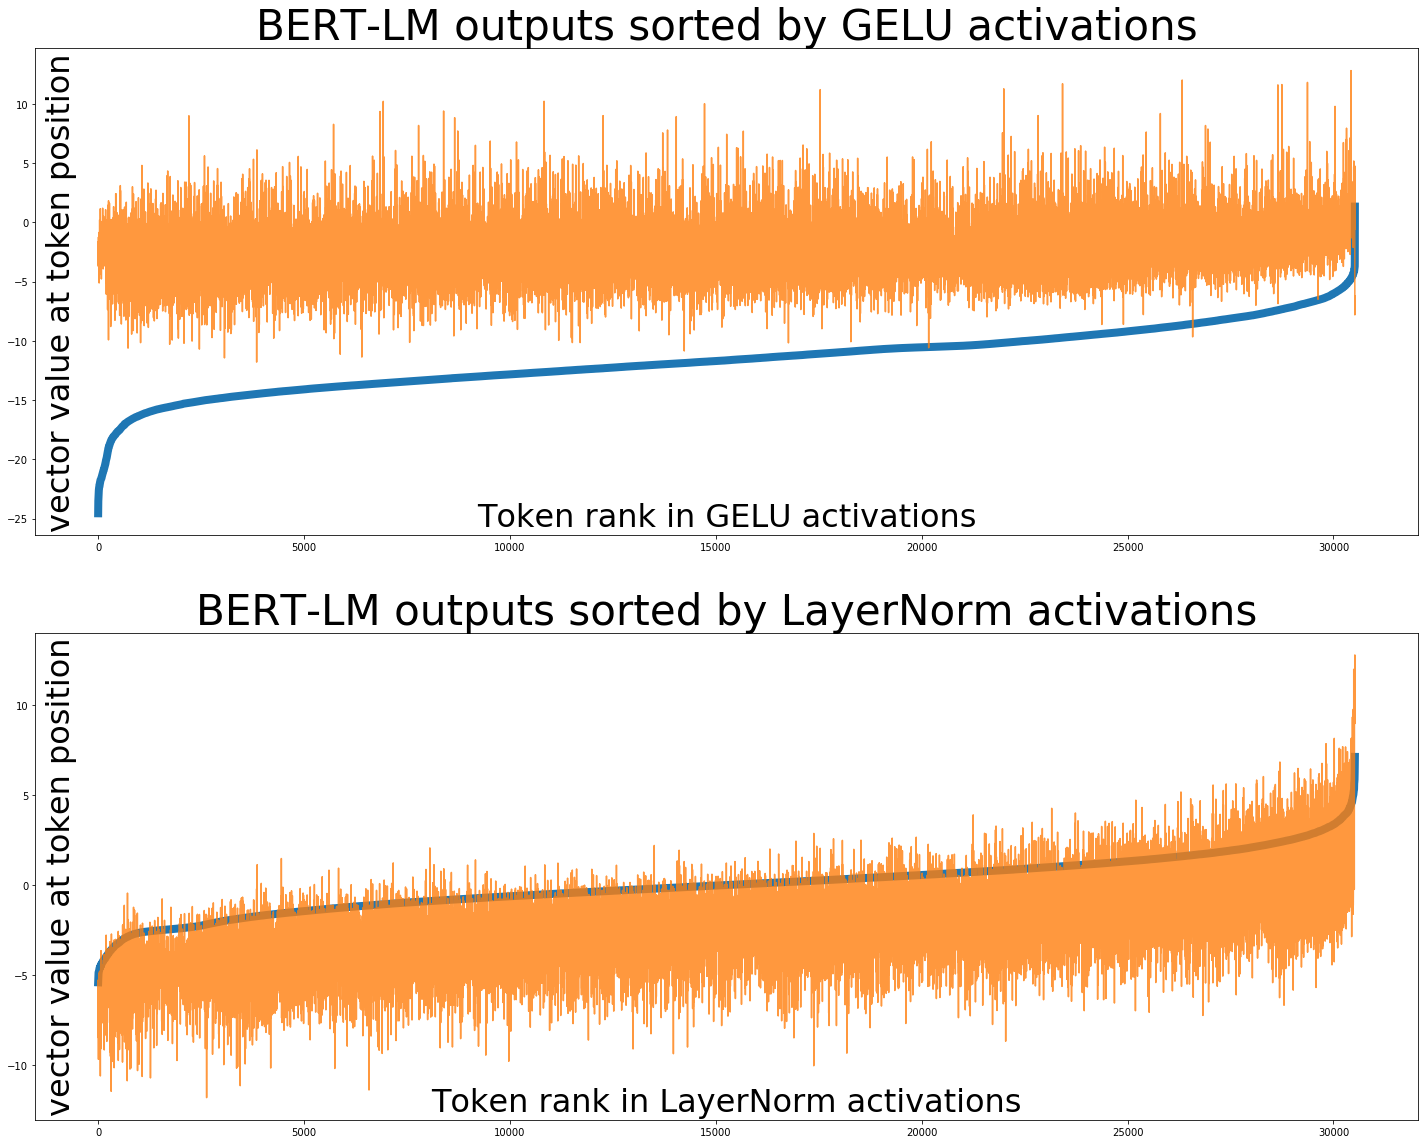

In [25]:

with pt.no_grad():
    n_items = 2
    fig = plt.figure(figsize=(20, 8 * n_items))
    axes = fig.subplots(n_items, 1)
    nice_names = ['headless activations',
                  'dense weight activations',
                  'dense bias activations',
                  'GELU activations',
                  'LayerNorm activations',
                  'elementwise weight product activations',
                  'elementwise bias addition activations']
    nax = 0
    for (i, (name, order)) in enumerate(orders_lm.items()):
        if name not in ('layernorm_center', 'layernorm_scale'):
            continue
        axes[nax].plot(values_lm[name][order], alpha=1, linewidth=8)
        axes[nax].plot(mybertlmout_values[order], alpha=.8)
        axes[nax].set_title(f'BERT-LM outputs sorted by {nice_names[i]}', fontsize=42)
        axes[nax].set_xlabel(f'Token rank in {nice_names[i]}', fontsize=32, labelpad=-50)
        axes[nax].set_ylabel('vector value at token position', fontsize=32, labelpad=-70)
#         axes[i][1].plot(mybertlmout_values[mybertlmout_order], alpha=.8)
#         axes[i][1].plot(values_lm[name][mybertlmout_order], alpha=.8)
#         axes[i][1].set_title(f'{name} by lmout', fontsize=24)
        nax += 1
    plt.subplots_adjust(left=.02, bottom=.02, right=.98, top=.95, wspace=None, hspace=None)
    plt.show()
    fig.savefig('2.m2 - all vs lmout.png')
    plt.close(fig)

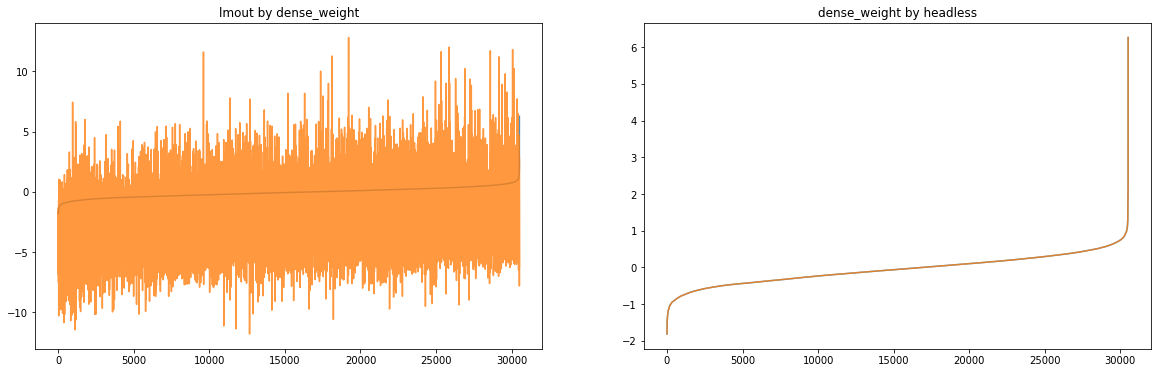

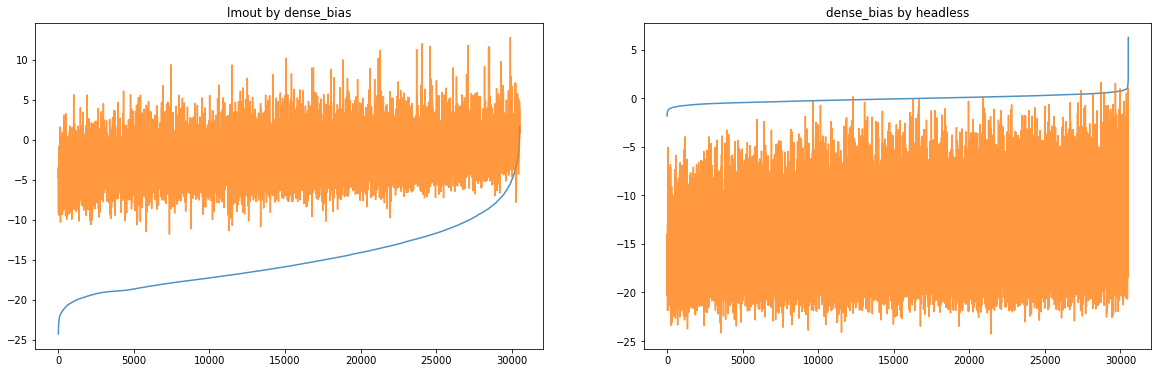

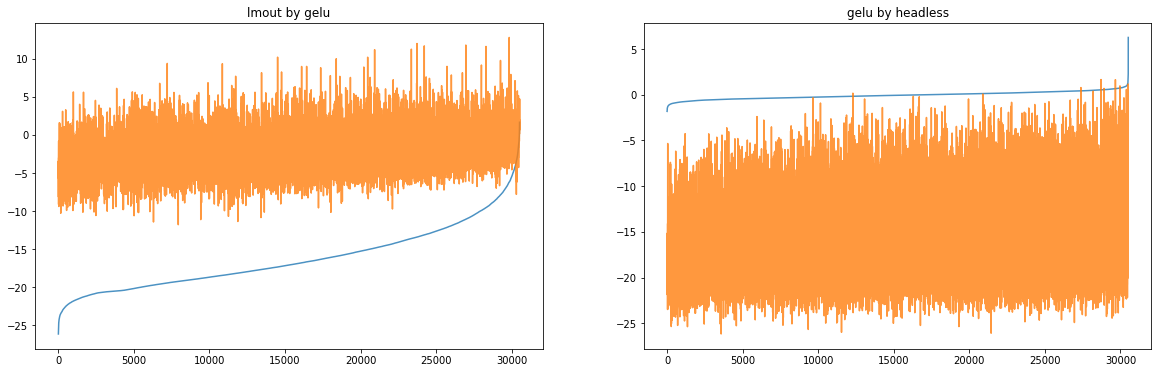

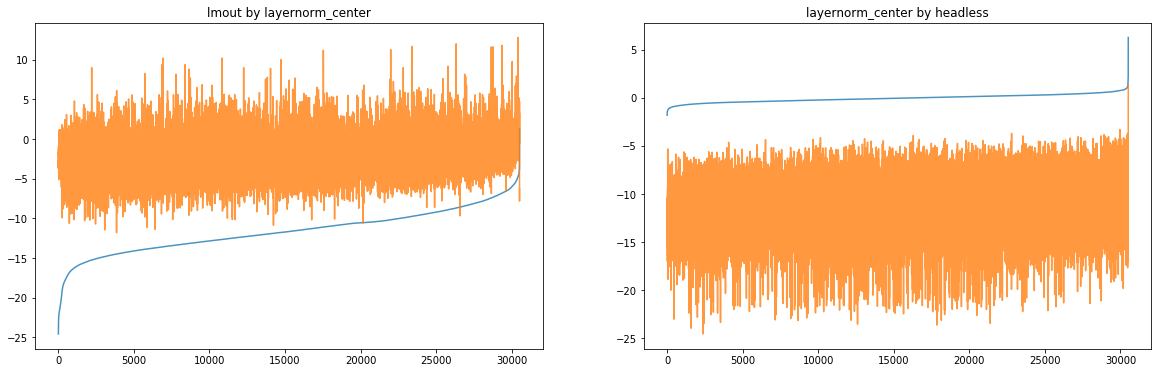

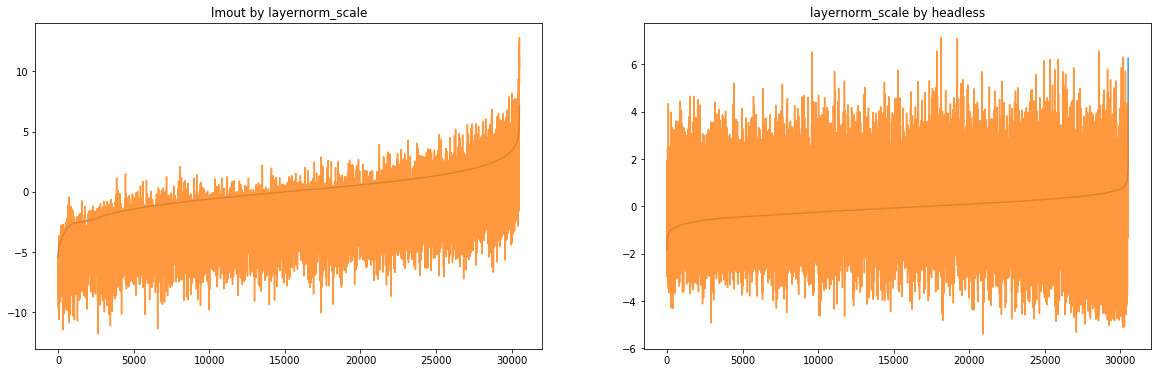

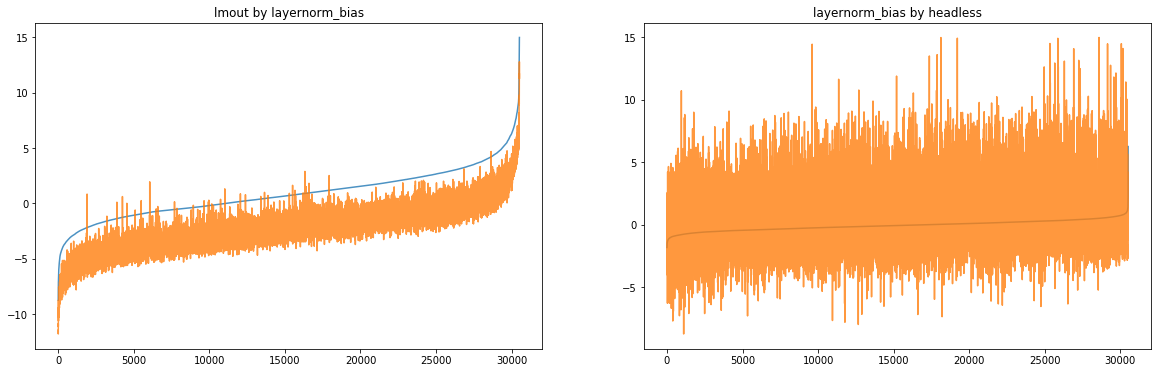

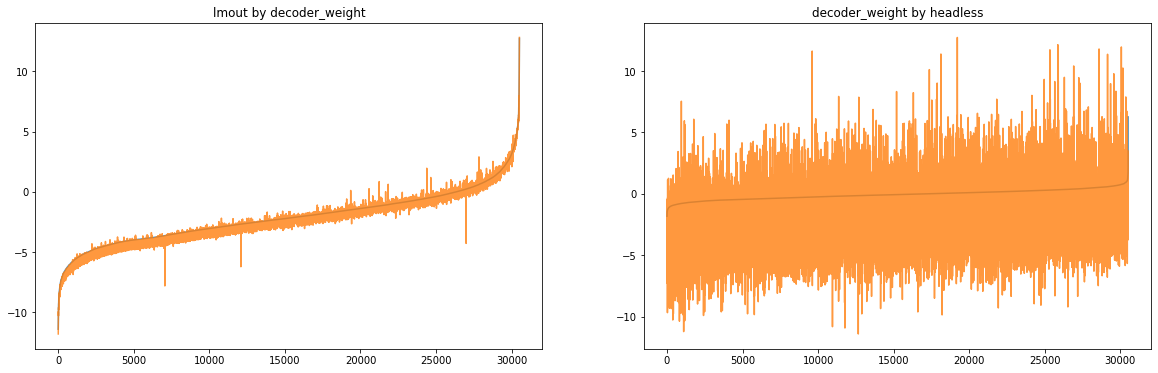

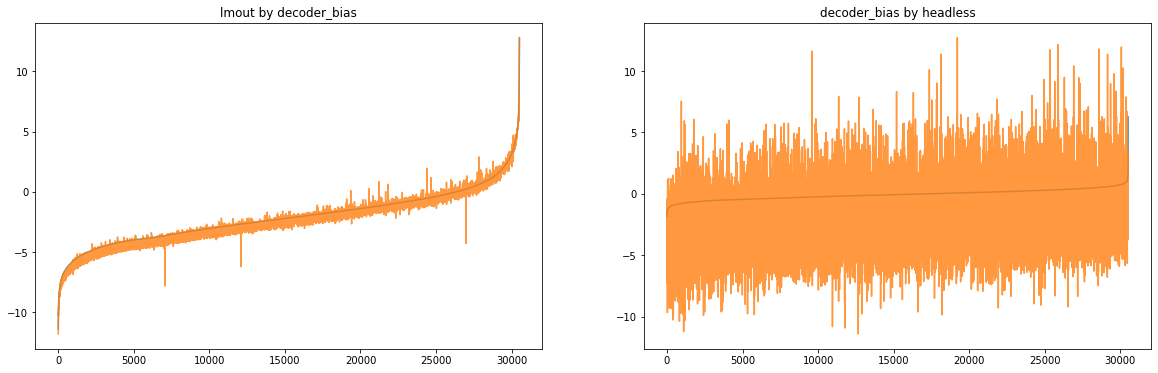

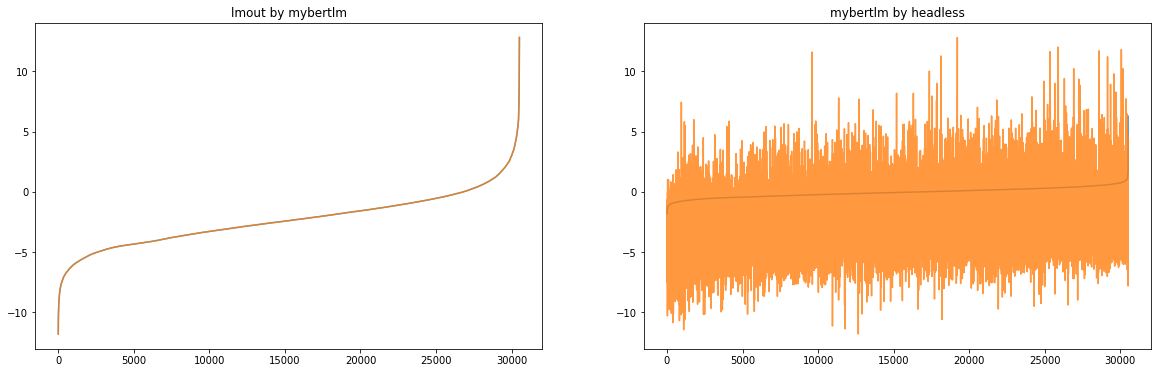

In [26]:
def plot_three(name, values, order):
    fig = plt.figure(figsize=(20, 6))
    ax1, ax2 = fig.subplots(1, 2)

    ax1.plot(values[order], alpha=.8)
    ax1.plot(mybertlmout_values[order], alpha=.8)
    ax1.set_title(f'lmout by {name}')

    ax2.plot(headless_values[headless_order], alpha=.8)
    ax2.plot(values[headless_order], alpha=.8)
    ax2.set_title(f'{name} by headless')

    plt.show()
    fig.savefig(f'{name} mixed.png')
    plt.close(fig)

with pt.no_grad():
    for name, order in orders_lm.items():
        plot_three(name, values_lm[name], order)
    plot_three('mybertlm', mybertlmout_values, mybertlmout_order)
        

In [27]:
with pt.no_grad():
    fig = plt.figure(figsize=(20, 6 * len(orders_lm)))
    axes = fig.subplots(len(orders_lm), 2)
    for (i, (name, order)) in enumerate(orders_lm.items()):
        axes[i][0].plot(values_lm[name][order], alpha=.8)
        axes[i][0].plot(mybertlmout_values[order], alpha=.8)
        axes[i][0].set_title(f'lmout by {name}', fontsize=24)
        axes[i][1].plot(headless_values[headless_order], alpha=.8)
        axes[i][1].plot(values_lm[name][headless_order], alpha=.8)
        axes[i][1].set_title(f'{name} by headless', fontsize=24)
    fig.savefig('3 - headless vs lmout.png')
    plt.close(fig)

In [28]:
matr = np.vstack([headless_values, 
             mybertlmout_values,
             values_lm['dense_weight'],
             values_lm['dense_bias'],
             values_lm['gelu'],
             values_lm['layernorm_center'],
             values_lm['layernorm_scale'],   
             values_lm['layernorm_bias'],
             values_lm['decoder_weight'],
             values_lm['decoder_bias']])
corrmatr = np.corrcoef(matr)
corrmatr

array([[ 1.        ,  0.25760317,  1.        ,  0.1568348 ,  0.15494754,
         0.09940443,  0.07271942,  0.21687497,  0.25708145,  0.25708145],
       [ 0.25760317,  1.        ,  0.25760317,  0.35087372,  0.34318797,
         0.2086961 ,  0.68339926,  0.95016388,  0.99671302,  0.99671302],
       [ 1.        ,  0.25760317,  1.        ,  0.1568348 ,  0.15494754,
         0.09940444,  0.07271942,  0.21687497,  0.25708145,  0.25708145],
       [ 0.1568348 ,  0.35087372,  0.1568348 ,  1.        ,  0.99963266,
         0.75379999,  0.40329867,  0.10904536,  0.30559382,  0.30559382],
       [ 0.15494754,  0.34318797,  0.15494754,  0.99963266,  1.        ,
         0.76077974,  0.40230977,  0.10025441,  0.29772159,  0.29772159],
       [ 0.09940443,  0.2086961 ,  0.09940444,  0.75379999,  0.76077974,
         1.        ,  0.03136457, -0.0312612 ,  0.19862855,  0.19862855],
       [ 0.07271942,  0.68339926,  0.07271942,  0.40329867,  0.40230977,
         0.03136457,  1.        ,  0.70262383

In [29]:
matr2 = np.vstack([ 
             values_lm['dense_weight'],
             values_lm['dense_bias'],
             values_lm['gelu'],
             values_lm['layernorm_center'],
             values_lm['layernorm_scale'],   
             values_lm['layernorm_bias'],
             values_lm['decoder_weight'],
             mybertlmout_values,])
corrmatr = np.corrcoef(matr2)
corrmatr

array([[ 1.        ,  0.1568348 ,  0.15494754,  0.09940444,  0.07271942,
         0.21687497,  0.25708145,  0.25760317],
       [ 0.1568348 ,  1.        ,  0.99963266,  0.75379999,  0.40329867,
         0.10904536,  0.30559382,  0.35087372],
       [ 0.15494754,  0.99963266,  1.        ,  0.76077974,  0.40230977,
         0.10025441,  0.29772159,  0.34318797],
       [ 0.09940444,  0.75379999,  0.76077974,  1.        ,  0.03136457,
        -0.0312612 ,  0.19862855,  0.2086961 ],
       [ 0.07271942,  0.40329867,  0.40230977,  0.03136457,  1.        ,
         0.70262383,  0.66123931,  0.68339926],
       [ 0.21687497,  0.10904536,  0.10025441, -0.0312612 ,  0.70262383,
         1.        ,  0.95879229,  0.95016388],
       [ 0.25708145,  0.30559382,  0.29772159,  0.19862855,  0.66123931,
         0.95879229,  1.        ,  0.99671302],
       [ 0.25760317,  0.35087372,  0.34318797,  0.2086961 ,  0.68339926,
         0.95016388,  0.99671302,  1.        ]])

In [30]:
for row in corrmatr:
    print(' & '.join(map(lambda x: f'{x:.4g}', row)))

1 & 0.1568 & 0.1549 & 0.0994 & 0.07272 & 0.2169 & 0.2571 & 0.2576
0.1568 & 1 & 0.9996 & 0.7538 & 0.4033 & 0.109 & 0.3056 & 0.3509
0.1549 & 0.9996 & 1 & 0.7608 & 0.4023 & 0.1003 & 0.2977 & 0.3432
0.0994 & 0.7538 & 0.7608 & 1 & 0.03136 & -0.03126 & 0.1986 & 0.2087
0.07272 & 0.4033 & 0.4023 & 0.03136 & 1 & 0.7026 & 0.6612 & 0.6834
0.2169 & 0.109 & 0.1003 & -0.03126 & 0.7026 & 1 & 0.9588 & 0.9502
0.2571 & 0.3056 & 0.2977 & 0.1986 & 0.6612 & 0.9588 & 1 & 0.9967
0.2576 & 0.3509 & 0.3432 & 0.2087 & 0.6834 & 0.9502 & 0.9967 & 1


In [31]:
def spearmatr(matr):
    return np.array([[Sr(np.vstack([x, y]).T).correlation for y in matr] for x in matr]), \
           np.array([[Sr(np.vstack([x, y]).T).pvalue for y in matr] for x in matr])
spearmatr_corr, spearmatr_p = spearmatr(matr2)

In [32]:
spearmatr_corr

array([[ 1.        ,  0.12640987,  0.12388287,  0.06393329,  0.08860482,
         0.22039769,  0.25696652,  0.25665973],
       [ 0.12640987,  1.        ,  0.99944047,  0.7123182 ,  0.42816371,
         0.12997439,  0.3258857 ,  0.36735901],
       [ 0.12388287,  0.99944047,  1.        ,  0.7196578 ,  0.42834956,
         0.12169291,  0.31836828,  0.36001811],
       [ 0.06393329,  0.7123182 ,  0.7196578 ,  1.        ,  0.0781692 ,
        -0.04211282,  0.18882742,  0.19888846],
       [ 0.08860482,  0.42816371,  0.42834956,  0.0781692 ,  1.        ,
         0.69519857,  0.65998429,  0.68148763],
       [ 0.22039769,  0.12997439,  0.12169291, -0.04211282,  0.69519857,
         1.        ,  0.94617955,  0.93612766],
       [ 0.25696652,  0.3258857 ,  0.31836828,  0.18882742,  0.65998429,
         0.94617955,  1.        ,  0.99621852],
       [ 0.25665973,  0.36735901,  0.36001811,  0.19888846,  0.68148763,
         0.93612766,  0.99621852,  1.        ]])

In [33]:
for row in spearmatr_corr:
    print(' & '.join(map(lambda x: f'{x:.4g}', row)))

1 & 0.1264 & 0.1239 & 0.06393 & 0.0886 & 0.2204 & 0.257 & 0.2567
0.1264 & 1 & 0.9994 & 0.7123 & 0.4282 & 0.13 & 0.3259 & 0.3674
0.1239 & 0.9994 & 1 & 0.7197 & 0.4283 & 0.1217 & 0.3184 & 0.36
0.06393 & 0.7123 & 0.7197 & 1 & 0.07817 & -0.04211 & 0.1888 & 0.1989
0.0886 & 0.4282 & 0.4283 & 0.07817 & 1 & 0.6952 & 0.66 & 0.6815
0.2204 & 0.13 & 0.1217 & -0.04211 & 0.6952 & 1 & 0.9462 & 0.9361
0.257 & 0.3259 & 0.3184 & 0.1888 & 0.66 & 0.9462 & 1 & 0.9962
0.2567 & 0.3674 & 0.36 & 0.1989 & 0.6815 & 0.9361 & 0.9962 & 1


In [34]:
spearmatr_p

array([[0.00000000e+000, 6.31777450e-109, 1.16874790e-104,
        5.08168632e-029, 2.98628633e-054, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [6.31777450e-109, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 4.27249545e-115,
        0.00000000e+000, 0.00000000e+000],
       [1.16874790e-104, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 4.94519015e-101,
        0.00000000e+000, 0.00000000e+000],
       [5.08168632e-029, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.39404880e-042, 1.83491610e-013,
        5.81650375e-243, 7.58350725e-270],
       [2.98628633e-054, 0.00000000e+000, 0.00000000e+000,
        1.39404880e-042, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 4.27249545e-115, 4.94519015e-101,
        1.83491610e-013, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.0000000

In [35]:
def heatplot(matr):
    fig = plt.figure(dpi=180)
    ax = fig.subplots()
    sns.heatmap(matr, 
            ax=ax, 
            linewidths=1, 
            robust=True, 
            square=True, 
            annot=True, 
            annot_kws={"size":6})
    b, t = plt.ylim()
    plt.ylim(b+.5, t-.5)
    labels = ('hlss', 'lm_o', 'dnsw', 'dnsb', 'gelu', 'ln_c', 'ln_s', 'ln_b', 'decw', 'decb')
    ax.set_xticklabels(labels, fontsize=6)
    ax.set_yticklabels(labels, fontsize=6)
    plt.show()
    fig.savefig('layers-crosscorr.png')
    plt.close(fig)

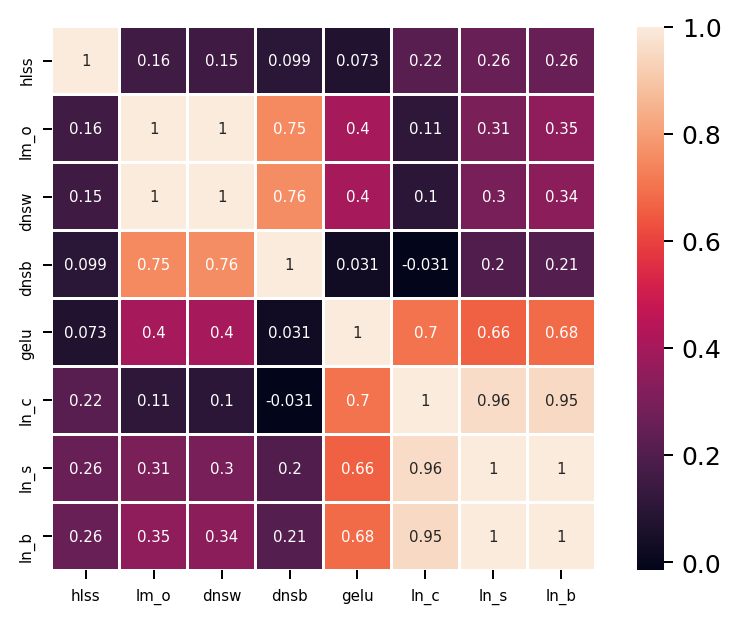

In [36]:
heatplot(corrmatr)

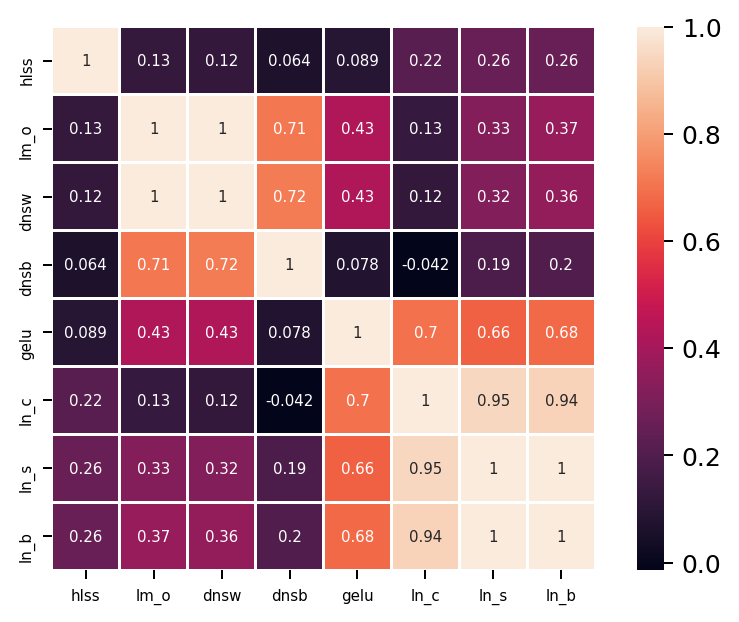

In [37]:
heatplot(spearmatr_corr)

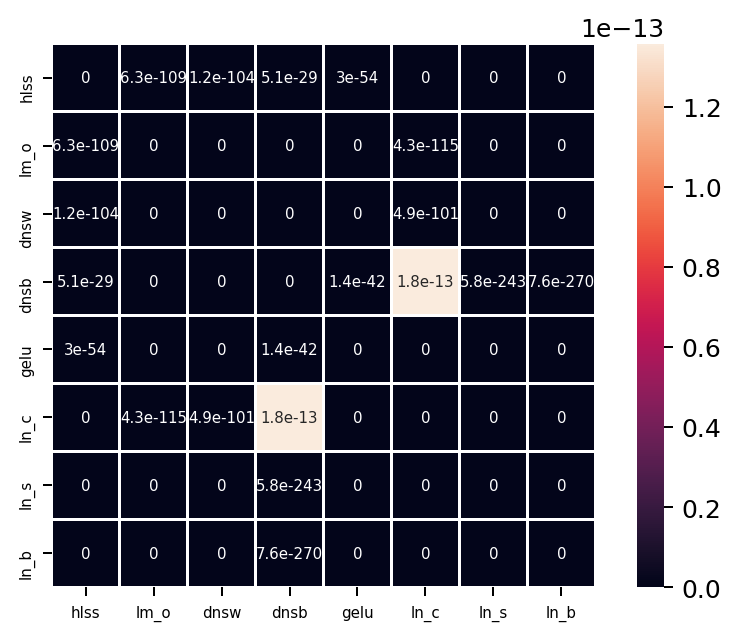

In [38]:
heatplot(spearmatr_p)